In [1]:
from feature_78_generation import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from graph_measures import *

In [4]:
finished_paths, unfinished_paths = load_paths(unquote_names=False, drop_timeouts=True)
nodes = pd.read_csv(GRAPH_METRICS_PATH)
metrics_dict = compute_path_metrics_w_nodes(
    nodes, unfinished_paths 
)

Total of paths:  19661
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_Lic

In [5]:
metrics_dict["path_degree"].reset_index(drop=True)

0                            [158, 197, 134]
1                                  [59, 129]
2                        [298, 154, 586, 38]
3        [40, 392, 1092, 185, 228, 209, 494]
4                   [8, 1845, 298, 133, 649]
                        ...                 
19656          [42, 1845, 210, 444, 82, 126]
19657      [41, 105, 102, 97, 221, 122, 109]
19658                      [20, 61, 155, 72]
19659                   [133, 1140, 870, 27]
19660                [35, 286, 119, 14, 123]
Length: 19661, dtype: object

In [6]:
for k,v in metrics_dict.items():
    too_short = 0
    all_nan = 0
    max_at_0 = 0
    max_at_end = 0
    print(f"Metric {k} of length {len(v)}")
    for i, val in enumerate(v):
        if len(val) < 3:
            too_short += 1
            continue
        if np.isnan(val).all():
            all_nan += 1
            continue
        if val[0] == np.nanmax(val):
            max_at_0 += 1
            continue
        if val[-1] == np.nanmax(val):
            max_at_end += 1
            continue
    print(f"Too short: {too_short}")
    print(f"All nan: {all_nan}")
    print(f"Max at 0: {max_at_0}")
    print(f"Max at end: {max_at_end}")
    print(f"Total issues: {too_short + all_nan + max_at_0 + max_at_end}")
    print(f"Total paths: {len(v)}")
    print("_"*20)


Metric path_degree of length 19661
Too short: 3580
All nan: 0
Max at 0: 636
Max at end: 3094
Total issues: 7310
Total paths: 19661
____________________
Metric path_clustering of length 19661
Too short: 3580
All nan: 0
Max at 0: 7197
Max at end: 2832
Total issues: 13609
Total paths: 19661
____________________
Metric path_degree_centrality of length 19661
Too short: 3580
All nan: 0
Max at 0: 636
Max at end: 3094
Total issues: 7310
Total paths: 19661
____________________
Metric path_betweenness of length 19661
Too short: 3580
All nan: 0
Max at 0: 716
Max at end: 3010
Total issues: 7306
Total paths: 19661
____________________
Metric path_closeness of length 19661
Too short: 3580
All nan: 0
Max at 0: 611
Max at end: 3070
Total issues: 7261
Total paths: 19661
____________________


In [7]:
def compute_metrics_slopes(metrics_dict):
    slopes = {}
    slope_bef = "slope_before_max"
    slope_aft = "slope_after_max"
    for k,v in metrics_dict.items():
        v.index = range(len(v))
        slopes[k] = {} 
        slopes[k][slope_bef] = []
        slopes[k][slope_aft] = []
        for i, val in enumerate(v):
            if len(val) < 3:
                slopes[k][slope_bef].append(np.nan)
                slopes[k][slope_aft].append(np.nan)
                continue
            if np.isnan(val).all():
                slopes[k][slope_bef].append(np.nan)
                slopes[k][slope_aft].append(np.nan)
                continue
            max_idx = np.nanargmax(metrics_dict["path_degree"][i])
            if max_idx == 0:
                slopes[k][slope_bef].append(np.nan)
                slopes[k][slope_aft].append(np.nan)
                continue
            if max_idx == len(val) - 1:
                slopes[k][slope_bef].append(np.nan)
                slopes[k][slope_aft].append(np.nan)
                continue
            before_max = val[:max_idx]
            after_max = val[max_idx+1:]
            
            before_too_short = len(before_max) < 2
            after_too_short = len(after_max) < 2
            
            slopes[k][slope_bef].append(np.polyfit(range(len(before_max)), before_max, 1)[0] if not before_too_short else np.nan)
            slopes[k][slope_aft].append(np.polyfit(range(len(after_max)), after_max, 1)[0] if not after_too_short else np.nan)
        slopes[k] = pd.DataFrame.from_dict(slopes[k], orient="index").T
        slopes[k].columns = [str(k + "_slope_before"), str(k + "_slope_after")]
        
    return slopes

In [8]:
slopes = compute_metrics_slopes(metrics_dict)

In [9]:
slopes["path_degree"]

,path_degree_slope_before,path_degree_slope_after
0,NaN,NaN
1,NaN,NaN
2,-144.0,NaN
3,352.0,90.8
4,NaN,175.5
...,...,...
19656,NaN,-61.4
19657,16.5,-13.0
19658,41.0,NaN
19659,NaN,-843.0


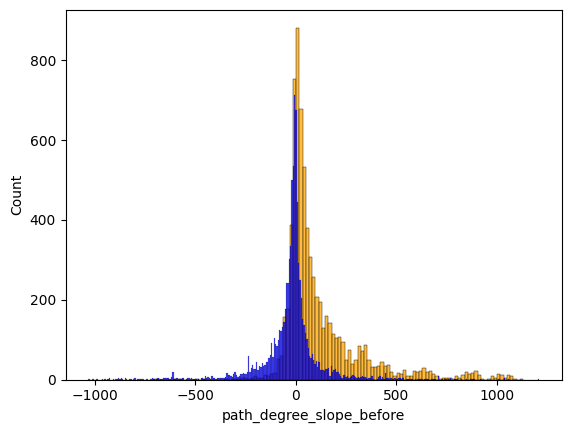

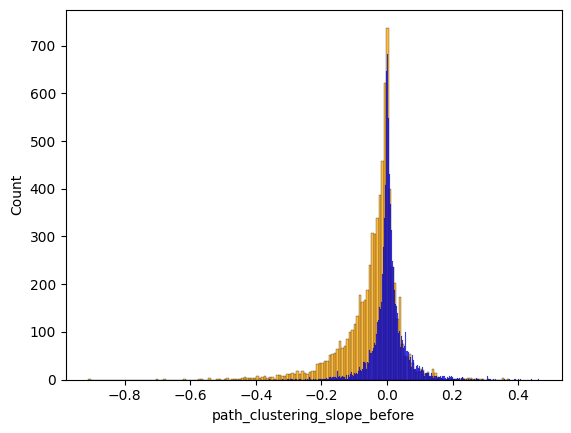

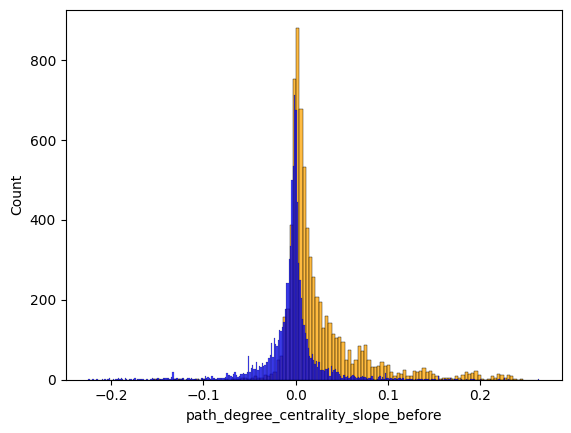

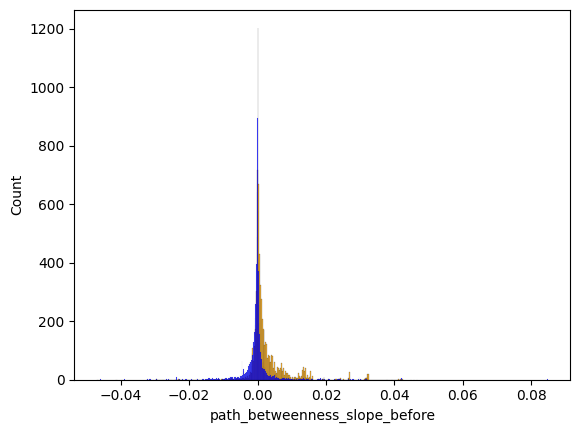

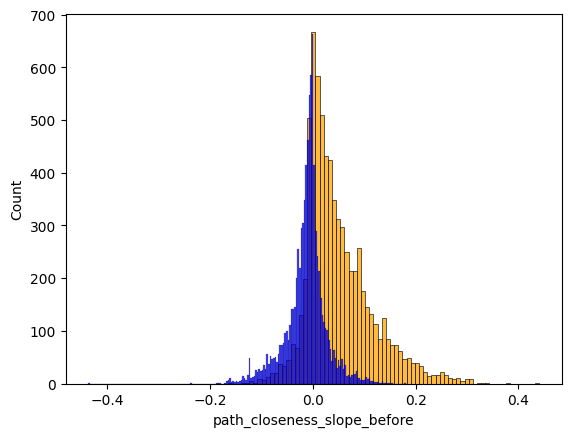

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
logging.getLogger().setLevel(logging.INFO)

for k,v in slopes.items():
    sns.histplot(data=v, x=v.columns[0], color="orange")
    sns.histplot(data=v, x=v.columns[1], color="blue")
    plt.show()
    # metric = metric.fillna(0)
    # sns.histplot(data=metric, x=metric.columns[0], color="orange")
    # sns.histplot(data=metric, x=metric.columns[1], color="blue")
    # plt.show()

In [11]:
finished_metrics_dict = compute_path_metrics_w_nodes(
    nodes, finished_paths 
)
for k,v in finished_metrics_dict.items():
    too_short = 0
    all_nan = 0
    max_at_0 = 0
    max_at_end = 0
    print(f"Metric {k} of length {len(v)}")
    for i, val in enumerate(v):
        if len(val) < 3:
            too_short += 1
            continue
        if np.isnan(val).all():
            all_nan += 1
            continue
        if val[0] == np.nanmax(val):
            max_at_0 += 1
            continue
        if val[-1] == np.nanmax(val):
            max_at_end += 1
            continue
    print(f"Too short: {too_short}")
    print(f"All nan: {all_nan}")
    print(f"Max at 0: {max_at_0}")
    print(f"Max at end: {max_at_end}")
    print(f"Total issues: {too_short + all_nan + max_at_0 + max_at_end}")
    print(f"Total paths: {len(v)}")
    print("_"*20)


Total of paths:  51318
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_License not found in links
Page Wikipedia_Text_of_the_GNU_Free_Documentation_Lic

In [12]:
finished_metrics_dict

{'path_degree': 0        [102, 157, 216, 272, 375, 20, 689, 73, 31]
 1                          [102, 1092, 689, 73, 31]
 2            [102, 109, 173, 271, 220, 689, 73, 31]
 3                              [102, 185, 228, 360]
 4                [102, 635, 303, 64, 158, 220, 128]
                             ...                    
 51313                                [20, 191, 179]
 51314            [20, 65, 14, 453, 62, 22, 132, 47]
 51315           [20, 649, 923, 1044, 1845, 119, 27]
 51316                           [41, 649, 1845, 97]
 51317                                [26, 912, 354]
 Length: 51318, dtype: object,
 'path_clustering': 0        [0.1095451010886469, 0.1174738219895288, 0.082...
 1        [0.1095451010886469, 0.0293348265330622, 0.042...
 2        [0.1095451010886469, 0.2701413728495997, 0.143...
 3        [0.1095451010886469, 0.0811407381246689, 0.060...
 4        [0.1095451010886469, 0.0467700258397932, 0.040...
                                ...                 

In [13]:
finished_metrics_dict["path_degree"].reset_index(drop=True)

0        [102, 157, 216, 272, 375, 20, 689, 73, 31]
1                          [102, 1092, 689, 73, 31]
2            [102, 109, 173, 271, 220, 689, 73, 31]
3                              [102, 185, 228, 360]
4                [102, 635, 303, 64, 158, 220, 128]
                            ...                    
51313                                [20, 191, 179]
51314            [20, 65, 14, 453, 62, 22, 132, 47]
51315           [20, 649, 923, 1044, 1845, 119, 27]
51316                           [41, 649, 1845, 97]
51317                                [26, 912, 354]
Length: 51318, dtype: object

In [14]:
finished_slopes = compute_metrics_slopes(finished_metrics_dict)

In [17]:
finished_slopes["path_degree"]

,path_degree_slope_before,path_degree_slope_after
0,8.571429,-42.0
1,NaN,-329.0
2,39.800000,-42.0
3,NaN,NaN
4,NaN,-19.4
...,...,...
51313,NaN,NaN
51314,-3.000000,6.5
51315,334.600000,-92.0
51316,608.000000,NaN


In [15]:
finished_paths

,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,2011-02-15 03:26:49,166,"[14th_century, 15th_century, 16th_century, Pac...",NaN
1,3824310e536af032,2012-08-12 06:36:52,88,"[14th_century, Europe, Africa, Atlantic_slave_...",3.0
2,415612e93584d30e,2012-10-03 21:10:40,138,"[14th_century, Niger, Nigeria, British_Empire,...",NaN
3,64dd5cd342e3780c,2010-02-08 07:25:25,37,"[14th_century, Renaissance, Ancient_Greece, Gr...",NaN
4,015245d773376aab,2013-04-23 15:27:08,175,"[14th_century, Italy, Roman_Catholic_Church, H...",3.0
...,...,...,...,...,...
51313,15a13a1d66ef5456,2012-10-03 02:23:35,66,"[Yagan, Ancient_Egypt, Civilization]",NaN
51314,2ef7ac844cefda58,2011-03-16 05:42:18,165,"[Yagan, Folklore, Brothers_Grimm, <, 19th_cent...",3.0
51315,12863abb7887f890,2013-11-22 04:42:52,228,"[Yagan, Australia, England, France, United_Sta...",NaN
51316,19f8284371753362,2011-02-27 07:42:47,56,"[Yarralumla%2C_Australian_Capital_Territory, A...",1.0


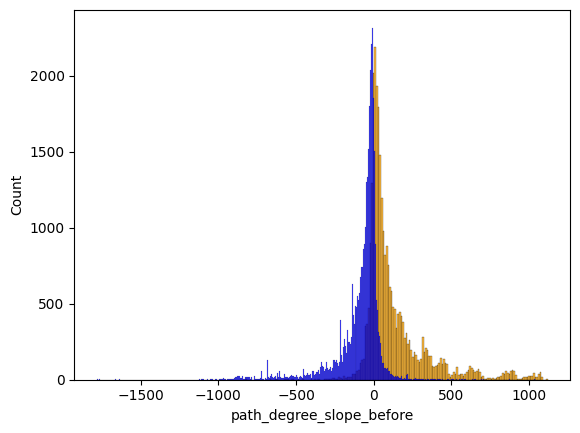

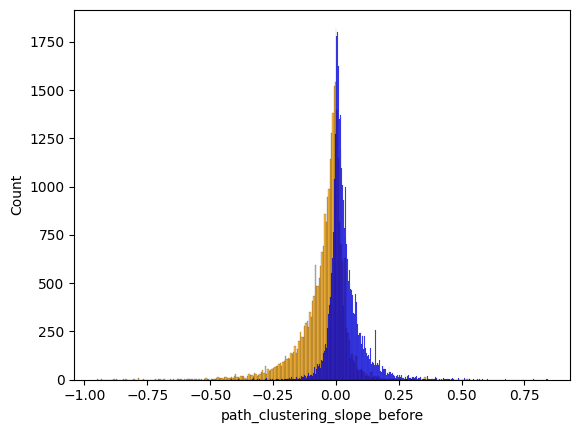

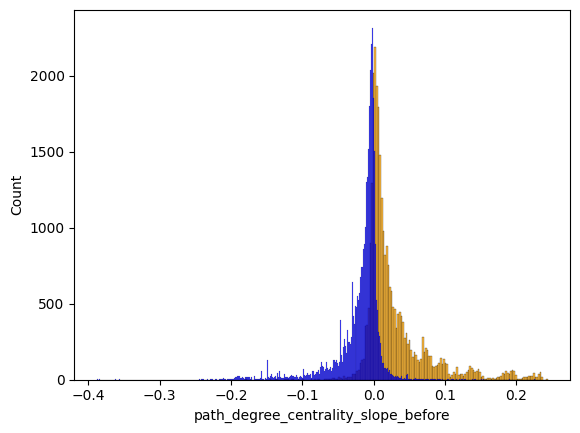

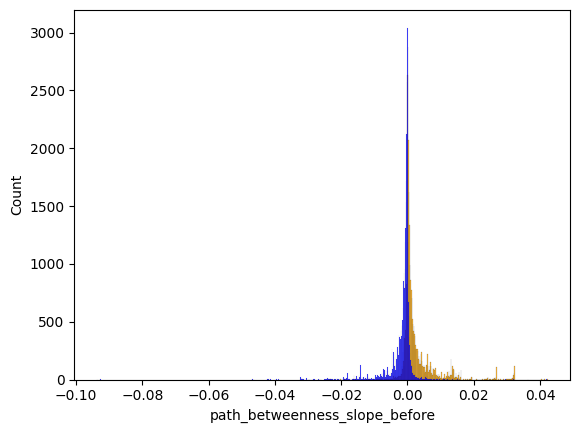

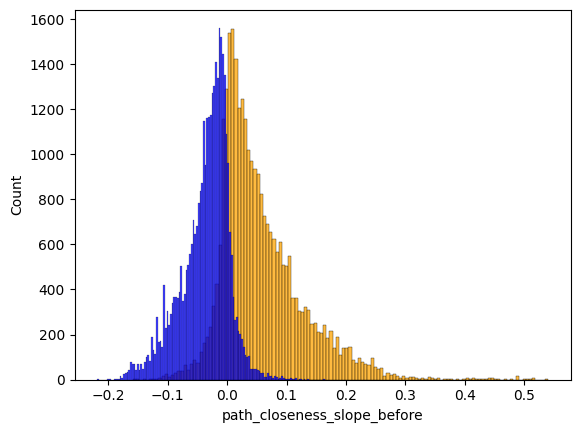

In [16]:
for k,v in finished_slopes.items():
    sns.histplot(data=v, x=v.columns[0], color="orange")
    sns.histplot(data=v, x=v.columns[1], color="blue")
    plt.show()

In [22]:
slopes_unfin_df = pd.DataFrame()
for k,v in slopes.items():
    slopes_unfin_df = pd.concat([slopes_unfin_df, v], axis=1)
slopes_unfin_df

,path_degree_slope_before,path_degree_slope_after,path_clustering_slope_before,path_clustering_slope_after,path_degree_centrality_slope_before,path_degree_centrality_slope_after,path_betweenness_slope_before,path_betweenness_slope_after,path_closeness_slope_before,path_closeness_slope_after
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-144.0,NaN,0.066452,NaN,-0.031366,NaN,-0.004739,NaN,-0.136704,NaN
3,352.0,90.8,-0.092775,-0.006180,0.076672,0.019778,0.003044,0.001783,0.134805,0.013284
4,NaN,175.5,NaN,-0.009101,NaN,0.038227,NaN,0.003802,NaN,0.014981
...,...,...,...,...,...,...,...,...,...,...
19656,NaN,-61.4,NaN,-0.012695,NaN,-0.013374,NaN,-0.000508,NaN,-0.016099
19657,16.5,-13.0,-0.008689,0.029832,0.003594,-0.002832,-0.000028,-0.000195,0.007270,0.028508
19658,41.0,NaN,-0.053902,NaN,0.008931,NaN,0.000361,NaN,0.088251,NaN
19659,NaN,-843.0,NaN,0.256437,NaN,-0.183620,NaN,-0.015222,NaN,-0.178428


In [24]:
paths_unfinised_modif = unfinished_paths.copy()
paths_unfinised_modif = pd.concat([paths_unfinised_modif, slopes_unfin_df], axis=1)
paths_unfinised_modif

,index,hashedIpAddress,timestamp,durationInSec,path,target,type,path_degree_slope_before,path_degree_slope_after,path_clustering_slope_before,path_clustering_slope_after,path_degree_centrality_slope_before,path_degree_centrality_slope_after,path_betweenness_slope_before,path_betweenness_slope_after,path_closeness_slope_before,path_closeness_slope_after
0,2,2b015fb8181c48f2,2011-02-07 15:00:19,1818,"[Malawi, Democracy, Alexander_the_Great]",First_Crusade,timeout,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4,53a53bc244e08a6a,2011-02-07 17:18:25,1808,"[Paraguay, Bolivia]",Mount_St._Helens,timeout,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,131600803df4895e,2011-02-07 17:42:37,2009,"[Agriculture, History_of_the_world, China, Yan...",Grand_Canal_of_China,timeout,-144.0,NaN,0.066452,NaN,-0.031366,NaN,-0.004739,NaN,-0.136704,NaN
3,6,486bb79910fe9dd2,2011-02-07 18:01:00,1932,"[Mind, Christianity, Europe, Renaissance, Anci...",Scouting,timeout,352.0,90.8,-0.092775,-0.006180,0.076672,0.019778,0.003044,0.001783,0.134805,0.013284
4,7,6d136e371e42474f,2011-02-07 18:07:50,175,"[4-2-0, United_States, Agriculture, Sugar, Aus...",Cane_Toad,restart,NaN,175.5,NaN,-0.009101,NaN,0.038227,NaN,0.003802,NaN,0.014981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19656,24869,109ed71f571d86e9,2014-01-15 12:00:12,182,"[Turks_and_Caicos_Islands, United_States, Iraq...",Iraq_War,restart,NaN,-61.4,NaN,-0.012695,NaN,-0.013374,NaN,-0.000508,NaN,-0.016099
19657,24870,109ed71f571d86e9,2014-01-15 12:06:45,180,"[Franz_Kafka, Tuberculosis, World_Health_Organ...",Cholera,restart,16.5,-13.0,-0.008689,0.029832,0.003594,-0.002832,-0.000028,-0.000195,0.007270,0.028508
19658,24872,2e09a7224600a7cd,2014-01-15 15:06:40,1900,"[Computer_programming, Linguistics, Culture, P...",The_Beatles,timeout,41.0,NaN,-0.053902,NaN,0.008931,NaN,0.000361,NaN,0.088251,NaN
19659,24873,60af9e2138051b96,2014-01-15 15:24:41,1903,"[Jamaica, United_Kingdom, World_War_II, Battle...",Alan_Turing,timeout,NaN,-843.0,NaN,0.256437,NaN,-0.183620,NaN,-0.015222,NaN,-0.178428


In [27]:
paths_unfinised_modif.to_csv("paths_unfinised_modif.csv", index=False)

In [25]:
slopes_fin_df = pd.DataFrame()
for k,v in finished_slopes.items():
    slopes_fin_df = pd.concat([slopes_fin_df, v], axis=1)
slopes_fin_df

,path_degree_slope_before,path_degree_slope_after,path_clustering_slope_before,path_clustering_slope_after,path_degree_centrality_slope_before,path_degree_centrality_slope_after,path_betweenness_slope_before,path_betweenness_slope_after,path_closeness_slope_before,path_closeness_slope_after
0,8.571429,-42.0,0.011691,0.054550,0.001867,-0.009148,0.000526,-0.000400,0.000736,-0.055022
1,NaN,-329.0,NaN,0.075132,NaN,-0.071662,NaN,-0.012097,NaN,-0.097114
2,39.800000,-42.0,-0.026961,0.054550,0.008669,-0.009148,0.000654,-0.000400,0.012319,-0.055022
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,-19.4,NaN,0.006470,NaN,-0.004226,NaN,-0.000219,NaN,-0.007018
...,...,...,...,...,...,...,...,...,...,...
51313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51314,-3.000000,6.5,0.051676,-0.020350,-0.000653,0.001416,0.000002,-0.000109,0.052335,-0.005320
51315,334.600000,-92.0,-0.029166,0.360789,0.072882,-0.020039,0.005587,-0.003235,0.085981,-0.107762
51316,608.000000,NaN,-0.222287,NaN,0.132433,NaN,0.012525,NaN,0.237505,NaN


In [26]:
finished_paths_modif = finished_paths.copy()
finished_paths_modif = pd.concat([finished_paths_modif, slopes_fin_df], axis=1)
finished_paths_modif

,hashedIpAddress,timestamp,durationInSec,path,rating,path_degree_slope_before,path_degree_slope_after,path_clustering_slope_before,path_clustering_slope_after,path_degree_centrality_slope_before,path_degree_centrality_slope_after,path_betweenness_slope_before,path_betweenness_slope_after,path_closeness_slope_before,path_closeness_slope_after
0,6a3701d319fc3754,2011-02-15 03:26:49,166,"[14th_century, 15th_century, 16th_century, Pac...",NaN,8.571429,-42.0,0.011691,0.054550,0.001867,-0.009148,0.000526,-0.000400,0.000736,-0.055022
1,3824310e536af032,2012-08-12 06:36:52,88,"[14th_century, Europe, Africa, Atlantic_slave_...",3.0,NaN,-329.0,NaN,0.075132,NaN,-0.071662,NaN,-0.012097,NaN,-0.097114
2,415612e93584d30e,2012-10-03 21:10:40,138,"[14th_century, Niger, Nigeria, British_Empire,...",NaN,39.800000,-42.0,-0.026961,0.054550,0.008669,-0.009148,0.000654,-0.000400,0.012319,-0.055022
3,64dd5cd342e3780c,2010-02-08 07:25:25,37,"[14th_century, Renaissance, Ancient_Greece, Gr...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,015245d773376aab,2013-04-23 15:27:08,175,"[14th_century, Italy, Roman_Catholic_Church, H...",3.0,NaN,-19.4,NaN,0.006470,NaN,-0.004226,NaN,-0.000219,NaN,-0.007018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51313,15a13a1d66ef5456,2012-10-03 02:23:35,66,"[Yagan, Ancient_Egypt, Civilization]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51314,2ef7ac844cefda58,2011-03-16 05:42:18,165,"[Yagan, Folklore, Brothers_Grimm, <, 19th_cent...",3.0,-3.000000,6.5,0.051676,-0.020350,-0.000653,0.001416,0.000002,-0.000109,0.052335,-0.005320
51315,12863abb7887f890,2013-11-22 04:42:52,228,"[Yagan, Australia, England, France, United_Sta...",NaN,334.600000,-92.0,-0.029166,0.360789,0.072882,-0.020039,0.005587,-0.003235,0.085981,-0.107762
51316,19f8284371753362,2011-02-27 07:42:47,56,"[Yarralumla%2C_Australian_Capital_Territory, A...",1.0,608.000000,NaN,-0.222287,NaN,0.132433,NaN,0.012525,NaN,0.237505,NaN
